In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

from lime import lime_image

d:\My Project\mlops deeplearning-ai\notebooks\model_interpretability\venv39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


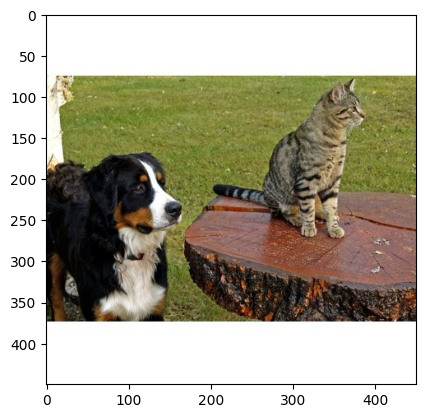

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./dogs.png')
plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

#### Load inception v3 Model

In [4]:
model = models.inception_v3(pretrained=True)

d:\My Project\mlops deeplearning-ai\notebooks\model_interpretability\venv39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\My Project\mlops deeplearning-ai\notebooks\model_interpretability\venv39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Load Inception v3 labels

In [5]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

In [6]:
print(len(cls2idx))

1000


#### Run predictions

In [7]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [8]:
logits.shape

torch.Size([1, 1000])

##### Get top 5 predictions

In [9]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.93592983, 239, 'Bernese_mountain_dog'),
 (0.0384481, 241, 'EntleBucher'),
 (0.023756392, 240, 'Appenzeller'),
 (0.0018181934, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113358e-06, 214, 'Gordon_setter'))

#### Background
- Trade off between interpretability and perdictive performance
- LIME can be used with any black box classifier
- Feeds the black-box model with small variations of the original data sample and probes how the model’s predictions change
- LIME segment image into different area, each segment treated as a feature
- LIME create the training dataset Z’, Z’ has the N features corresponding to N segment areas, and for each observation in Z’, randomly set each feature value as 0 or 1
- Map each Z' back to a new image, the mapping rule is, Z’ feature value 1, maps to corresponding segment area of the original image, but if 0, then we set the corresponding segment area pixels as 0 in the mapped image
- Input Z(mapped image set) into the trained model f to get target values f(Z)

##### Steps
1. Choosing the data sampel to be explained (could be a point from your validation set that your model made a mistake or any random sample)

2. Perturbing the sample

3. Labelling the perturbed samples with the black-box model

4. Weighting -  to learn the interpretable model, LIME weights the samples according to their proximity to x', so samples close to x' are given a large weight, and samples far from x' are given a small weight

5. Learning the interpretable model - The default interpretable model used by LIME is a linear model, even though the black-box model might be nonlinear, we expect that close to x', the decision boundary can be reasonably approximated by a line.

#### Apply Lime (Local Interpretable Model-agnostic Explanations)
- Lime produces array of images from original input image by pertubation algorithm
- 2 inputs : 
    (a) original image as numpy array 
    (b) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output

In [10]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [11]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [12]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

#### Lime Image Explainer - Explain predictions in Image data
- Functions: 
    (a) explain_instance
    (b) data_labels


##### explain_instance: 
- image: 3 dimension RGB image
- classifier_fn: lassifier prediction probability function (outputs prediction probabilities)
- labels: iterable with labels to be explained
- top_labels: the K labels with highest prediction probabilities
- num_features: maximum number of features present in explanation
- num_samples: maximum number of features present in explanation

1. Increasing the number of perturbed samples can improve the stability and accuracy of the explanations

2. Choosing an appropriate interpretable model (e.g., linear regression, decision tree) can impact the quality of explanations

3. Customizing the number of features used in the explanation can help focus on the most important contributors to the prediction

In [13]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


In [14]:
from skimage.segmentation import mark_boundaries

In [18]:
print(explanation.top_labels)

[239, 241, 240, 238, 214]

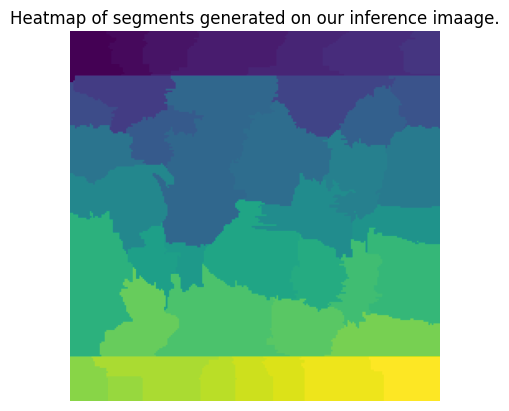

In [30]:
plt.imshow(explanation.segments)
plt.title("Heatmap of segments generated on our inference imaage.")
plt.axis('off')
plt.show()

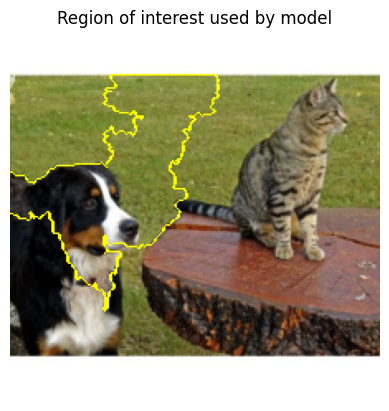

In [35]:
# Positive only : Only take superpixels that positively contribute to the prediction of the label
# Negative only: Only take superpixels that negatively contribute
# hide_rest: Make the non explanation part of image gray
# num_features: Number of superprixels to include in explanation
# min_weight: Minimum weight of superpixesl to be considered
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.2)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.title("Region of interest used by model")
plt.axis('off')
plt.show()

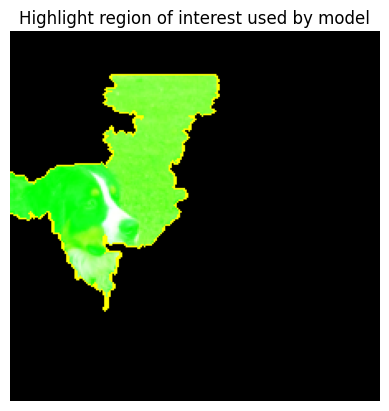

In [36]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, negative_only=False, num_features=10, hide_rest=True, min_weight=0.2)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.title("Highlight region of interest used by model")
plt.axis('off')
plt.show()

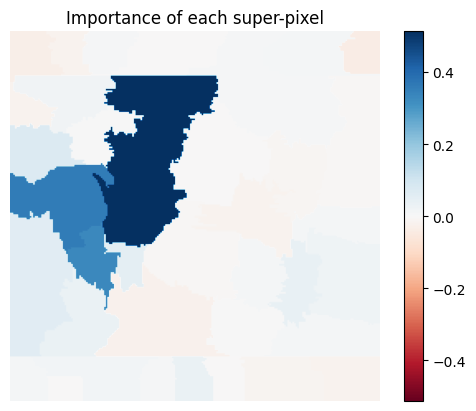

In [37]:
# Show how important each super-pixel is 

def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.title("Importance of each super-pixel")
    plt.axis('off')
    plt.colorbar()
    plt.show()

explanation_heatmap(explanation, explanation.top_labels[0])